In [1]:
import functools
import random
import copy

import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model

import matplotlib.pyplot as plt
import seaborn as sns
import ase

In [220]:
# Read the data
datafile = "data/2d_mat_dataset_raw.pkl"
data = pd.read_pickle(datafile)
initial_size = len(data)
data.head()

data.describe()

,energy_per_atom (eV),decomposition_energy (eV/atom),exfoliation_energy_per_atom (eV/atom),energy_vdw_per_atom (eV/atom),total_magnetization (Bohr Magneton),bandgap (eV),ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
count,6156.000000,6155.000000,4527.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,...,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000
mean,-4.881024,0.267288,0.150947,-3.906346,1.141026,1.048038,30.551707,145.693877,218.450531,16.383647,...,1.694379,2.957330,0.321291,7.610770,172.140293,179.218863,207.894032,331.316360,1768.938491,3.019394
std,1.594898,0.354539,0.204484,1.749797,3.204535,1.443890,16.259585,16.673223,22.887152,4.397442,...,0.494663,1.144204,0.221893,23.357869,24.092420,31.254298,26.685245,49.932611,1462.546851,2.935489
min,-10.724971,0.000000,-1.218706,-9.769199,-10.014716,0.000000,2.000000,85.000000,163.000000,4.600000,...,0.000000,1.000000,0.113000,0.005650,110.000000,120.000000,162.000000,245.100000,206.000000,0.557000
25%,-5.960577,0.039261,0.058429,-5.128683,-0.000000,0.000000,17.500000,137.258855,197.569231,13.650000,...,1.000000,2.000000,0.159000,0.026580,152.000000,150.000000,182.000000,292.900000,317.500000,0.802000
50%,-4.794826,0.146934,0.089230,-3.912666,0.000000,0.221500,28.000000,145.375888,222.272727,15.643333,...,2.000000,3.000000,0.234000,0.120000,175.000000,182.000000,215.000000,317.000000,1790.000000,2.900000
75%,-3.748102,0.359714,0.166131,-2.637456,0.245163,1.822050,41.732143,153.826394,236.000000,18.300000,...,2.000000,4.000000,0.443000,0.520000,190.000000,191.000000,229.000000,352.200000,2826.915883,4.310000
max,-0.216389,3.469618,3.056498,1.782194,44.005684,9.449400,85.666667,235.000000,293.000000,47.450000,...,2.000000,6.000000,1.824000,235.000000,268.000000,303.000000,307.000000,450.000000,18350.000000,39.700000


In [3]:
# Drop columns where we don't even have two unique values
descriptor_cols = set(data.columns[14:])

def drop_low_unique_columns(data, descriptor_cols, cutoff=1):
    low_unique_data = data[descriptor_cols].loc[:,data[descriptor_cols].nunique() <= cutoff]
    cols_to_drop = low_unique_data.columns
    return data.drop(columns=list(cols_to_drop))

# Display the dropped columns to the user
data = drop_low_unique_columns(data, descriptor_cols)
descriptor_cols = list(descriptor_cols.intersection(set(data.columns)))

In [4]:
# Get datasets
decomp_target = "decomposition_energy (eV/atom)"
exfol_target = "exfoliation_energy_per_atom (eV/atom)"
bg_target = "bandgap (eV)"


def get_dataset_subset(target_column, feature_columns, full_dataset):
    # Generate Dataset
    initial_size = len(full_dataset)
    result_data = full_dataset[[target_column] + feature_columns].dropna()
    print(f"Dropped {initial_size - len(result_data)} missing rows for target {target_column}")
    return result_data

data_extractor = functools.partial(get_dataset_subset, feature_columns=descriptor_cols, full_dataset=data)

decomp_data = data_extractor(decomp_target)
exfol_data = data_extractor(exfol_target)
bg_data = data_extractor(bg_target)

Dropped 196 missing rows for target decomposition_energy (eV/atom)
Dropped 1824 missing rows for target exfoliation_energy_per_atom (eV/atom)
Dropped 0 missing rows for target bandgap (eV)


In [5]:
# Train/Test Split
np.random.seed(1234)
random.seed(1234)

decomp_train, decomp_test = sklearn.model_selection.train_test_split(decomp_data, test_size=0.2)
exfol_train, exfol_test = sklearn.model_selection.train_test_split(exfol_data, test_size=0.2)
bg_train, bg_test = sklearn.model_selection.train_test_split(bg_data, test_size=0.2)

In [6]:
# Scale the training sets
decomp_scaler = sklearn.preprocessing.StandardScaler()
exfol_scaler = sklearn.preprocessing.StandardScaler()
bg_scaler = sklearn.preprocessing.StandardScaler()

decomp_scaled = pd.DataFrame(decomp_scaler.fit_transform(decomp_train), columns=decomp_train.columns)
exfol_scaled = pd.DataFrame(exfol_scaler.fit_transform(exfol_train), columns=exfol_train.columns)
bg_scaled = pd.DataFrame(bg_scaler.fit_transform(bg_train), columns=bg_train.columns)

In [7]:
# Write to CSV
decomp_scaled.to_csv("data/scaled_decomp_train.csv")
exfol_scaled.to_csv("data/scaled_exfol_train.csv")
bg_scaled.to_csv("data/scaled_bg_train.csv")

# Band Gaps

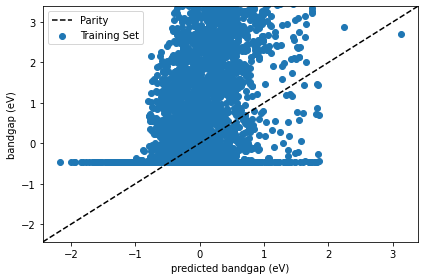

In [212]:
# This was done by hand based on the output of the SISSO runs
# Probably should write a script for this or get the Python bindings compiled...
# 4-dimensional features, Max cross correlation of 0.1, max rungs 1, held out 10% as a validation set

# Note that all the features at this point have been scaled. We'll need to unscale the y's to get meaningful results.

# Band gaps
bg_preds = pd.DataFrame()
bg_preds[bg_target] = bg_scaled[bg_target].copy()
bg_preds["term0"] = bg_scaled["max:num_d_valence"] - bg_scaled["sum:heat_capacity_mass"]
bg_preds["term1"] = bg_scaled["var:en_pauling"] + bg_scaled["max:vdw_radius_uff"]
bg_preds["term2"] = bg_scaled["min:gs_energy"] * bg_scaled["ave:heat_of_formation"]
bg_preds["term3"] = bg_scaled["ave:gs_energy"] - bg_scaled["ave:covalent_radius_slater"]

# SISSO Regression
c0 = -1.044369238568654e-01
a0 = -1.315168413023301e-01
a1 = 2.246625014714412e-01
a2 = -1.934019562283296e-01
a3 = 3.895288031783604e-01
pred_bg_target = f"predicted {bg_target}"
bg_preds[pred_bg_target] = c0 + a0 * bg_preds.term0 + a1 * bg_preds.term1 + a2 * bg_preds.term2 + a3 * bg_preds.term3

# Unscale the predictions before we plot them
bg_preds[pred_decomp_target] = bg_preds[pred_bg_target] * bg_scaler.var_[0] + bg_scaler.mean_[0]
bg_preds[bg_target] = bg_preds[bg_target] * bg_scaler.var_[0] + bg_scaler.mean_[0]

# Create Plot
# Interestingly, when the model predicts a very low bandgap, the bandgap really is 0 (or negative, which is weird).
# Suggests we might have a better time training a classifier for metallicity than outright predicting the bandgap.
# Similarly, we might use this to predict whether a material is an insulator or UWBG material
plt.scatter(y=bg_preds[bg_target], x=bg_preds[pred_bg_target], label="Training Set")
axmin = min(plt.gca().get_xbound()[0], plt.gca().get_ybound()[0])
axmax = min(plt.gca().get_xbound()[1], plt.gca().get_ybound()[1])
plt.xlabel(pred_bg_target)
plt.ylabel(bg_target)
plt.xlim([axmin, axmax])
plt.ylim([axmin, axmax])
plt.plot([axmin, axmax], [axmin, axmax], c="black", linestyle="--", label='Parity')
plt.legend()
plt.tight_layout()
plt.show()

# Decomposition Energy

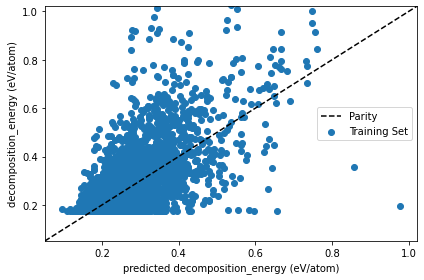

In [215]:
decomp_preds = pd.DataFrame()
decomp_preds[decomp_target] = decomp_scaled[decomp_target].copy()
decomp_preds["term0"] = decomp_scaled["min:gs_bandgap"] * decomp_scaled["var:heat_of_formation"]
decomp_preds["term1"] = decomp_scaled["ave:first_ion_en"] + decomp_scaled["min:evaporation_heat"]
decomp_preds["term2"] = np.exp(-decomp_scaled["sum:covalent_radius_pyykko_triple"])
decomp_preds["term3"] = decomp_scaled["ave:electron_affinity"] - decomp_scaled["ave:fusion_enthalpy"]

# SISSO Regression
c0 = -4.348686387090896e-01
a0 = 1.898873271854383e-01
a1 = 1.715304898374756e-01
a2 = 3.177375447416217e-01
a3 = -3.074491828132100e-01
pred_decomp_target = f"predicted {decomp_target}"
decomp_preds[pred_decomp_target] = c0 + a0 * decomp_preds.term0 + a1 * decomp_preds.term1 + a2 * decomp_preds.term2 + a3 * decomp_preds.term3

# Unscale the predictions before we plot them
decomp_preds[pred_decomp_target] = decomp_preds[pred_decomp_target] * decomp_scaler.var_[0] + decomp_scaler.mean_[0]
decomp_preds[decomp_target] = decomp_preds[decomp_target] * decomp_scaler.var_[0] + decomp_scaler.mean_[0]


# Create Plot
# Interestingly, when the model predicts a very low bandgap, the bandgap really is 0 (or negative, which is weird).
# Suggests we might have a better time training a classifier for metallicity than outright predicting the bandgap.
# Similarly, we might use this to predict whether a material is an insulator or UWBG material
plt.scatter(y=decomp_preds[decomp_target], x=decomp_preds[pred_decomp_target], label="Training Set")
axmin = min(plt.gca().get_xbound()[0], plt.gca().get_ybound()[0])
axmax = min(plt.gca().get_xbound()[1], plt.gca().get_ybound()[1])
plt.xlabel(pred_decomp_target)
plt.ylabel(decomp_target)
plt.xlim([axmin, axmax])
plt.ylim([axmin, axmax])
plt.plot([axmin, axmax], [axmin, axmax], c="black", linestyle="--", label='Parity')
plt.legend()
plt.tight_layout()
plt.show()

# Exfoliation Energy

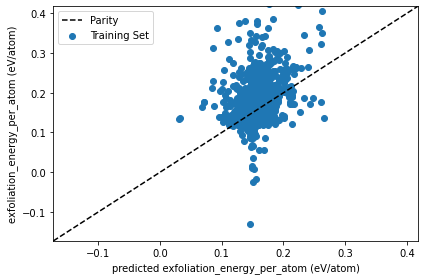

In [219]:
exfol_preds = pd.DataFrame()
exfol_preds[exfol_target] = exfol_scaled[exfol_target].copy()
exfol_preds["term0"] = exfol_scaled["max:num_p_valence"] / exfol_scaled["var:num_f_valence"]
exfol_preds["term1"] = exfol_scaled["var:sound_velocity"] * exfol_scaled["min:thermal_conductivity"]
exfol_preds["term2"] = exfol_scaled["var:num_p_unfilled"] - exfol_scaled["sum:boiling_point"]
exfol_preds["term3"] = exfol_scaled["min:evaporation_heat"] - exfol_scaled["min:thermal_conductivity"]

# SISSO Regression
c0 = -8.823692967856501e-03
a0 = 8.068651884569043e-02
a1 = 1.528021111506845e-01
a2 = 1.570306664512797e-01
a3 = 1.911739394694614e-01
pred_exfol_target = f"predicted {exfol_target}"
exfol_preds[pred_exfol_target] = c0 + a0 * exfol_preds.term0 + a1 * exfol_preds.term1 + a2 * exfol_preds.term2 + a3 * exfol_preds.term3

# Unscale the predictions before we plot them
exfol_preds[pred_exfol_target] = exfol_preds[pred_exfol_target] * exfol_scaler.var_[0] + exfol_scaler.mean_[0]
exfol_preds[exfol_target] = exfol_preds[exfol_target] * exfol_scaler.var_[0] + exfol_scaler.mean_[0]


# Create Plot
# Interestingly, when the model predicts a very low bandgap, the bandgap really is 0 (or negative, which is weird).
# Suggests we might have a better time training a classifier for metallicity than outright predicting the bandgap.
# Similarly, we might use this to predict whether a material is an insulator or UWBG material
plt.scatter(y=exfol_preds[exfol_target], x=exfol_preds[pred_exfol_target], label="Training Set")
axmin = min(plt.gca().get_xbound()[0], plt.gca().get_ybound()[0])
axmax = min(plt.gca().get_xbound()[1], plt.gca().get_ybound()[1])
plt.xlabel(pred_exfol_target)
plt.ylabel(exfol_target)
plt.xlim([axmin, axmax])
plt.ylim([axmin, axmax])
plt.plot([axmin, axmax], [axmin, axmax], c="black", linestyle="--", label='Parity')
plt.legend()
plt.tight_layout()
plt.show()